# Table of Contents
 <p>

In [54]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers.core import Dense, Activation

In [2]:
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.info()
print('-------------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare   

In [4]:
data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)

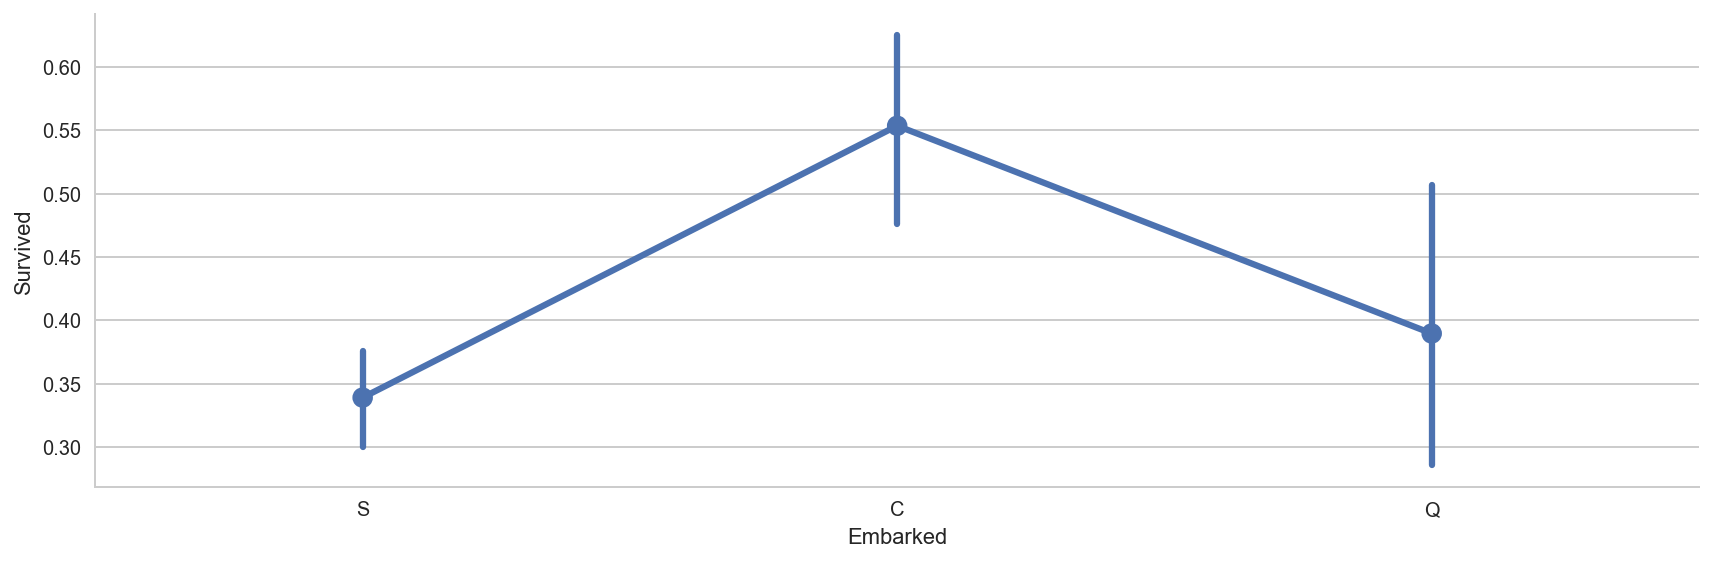

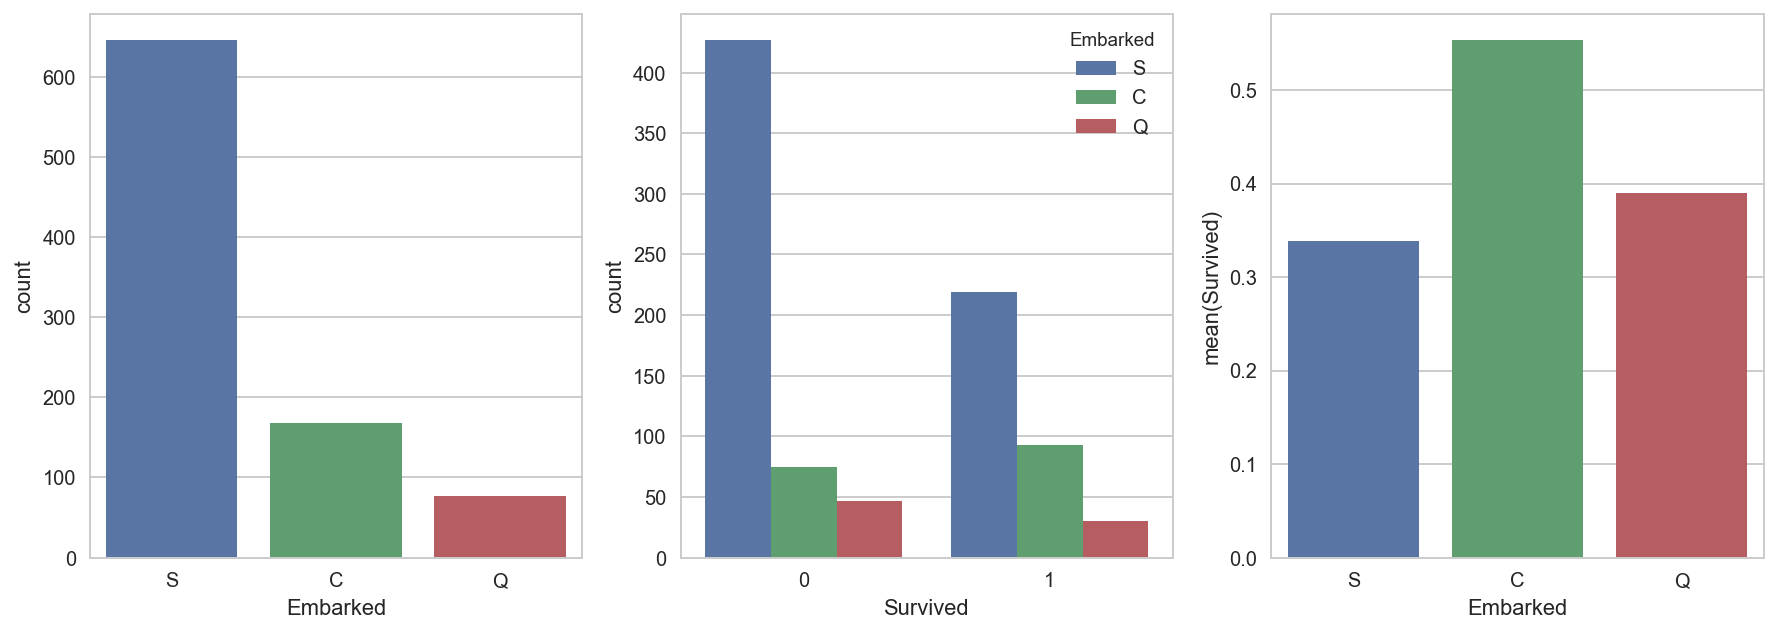

In [5]:
#补全Embarked数据并画图
data.Embarked = data.Embarked.fillna('S')

sns.factorplot('Embarked', 'Survived', data=data, size=4, aspect=3)
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='Embarked', data=data, ax=axis1)
sns.countplot(x='Survived', hue='Embarked', data=data, order=[0, 1], ax=axis2)

embark_prec = data[['Embarked', 'Survived']].groupby(
    ['Embarked'], as_index=False).mean()
sns.barplot(
    x='Embarked',
    y='Survived',
    data=embark_prec,
    order=['S', 'C', 'Q'],
    ax=axis3)

In [6]:
#删除Embarked中值为S的数据，因为其生存率很低
embarked_dummies_data = pd.get_dummies(data.Embarked)
embarked_dummies_data.drop(['S'], axis=1, inplace=True)

embarked_dummies_test = pd.get_dummies(test.Embarked)
embarked_dummies_test.drop(['S'], axis=1, inplace=True)

data = data.join(embarked_dummies_data)
test = test.join(embarked_dummies_test)

data.drop(['Embarked'], axis=1, inplace=True)
test.drop(['Embarked'], axis=1, inplace=True)

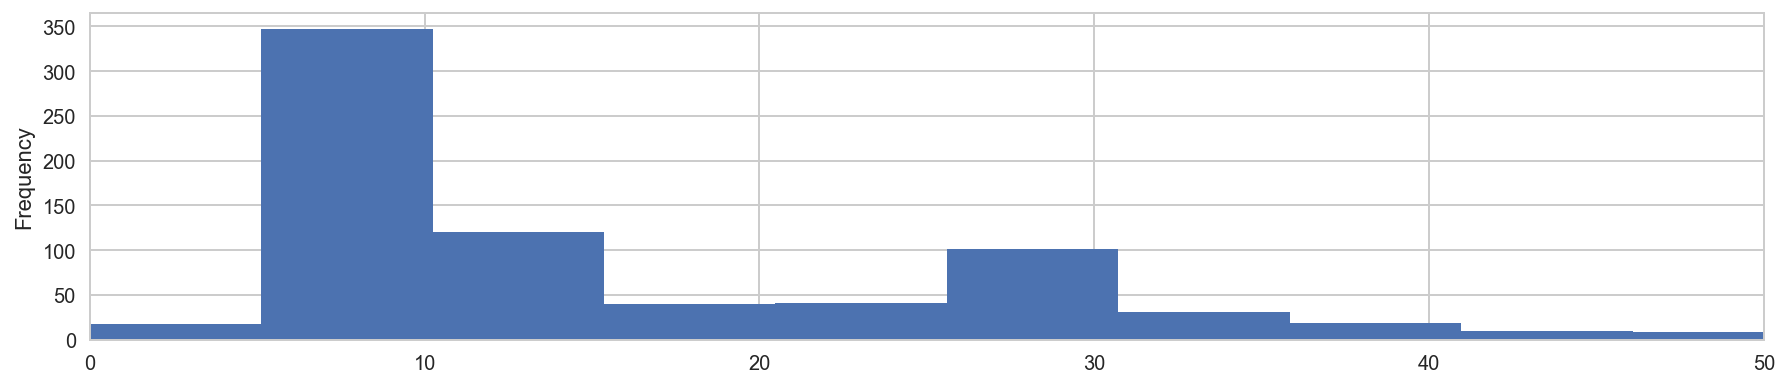

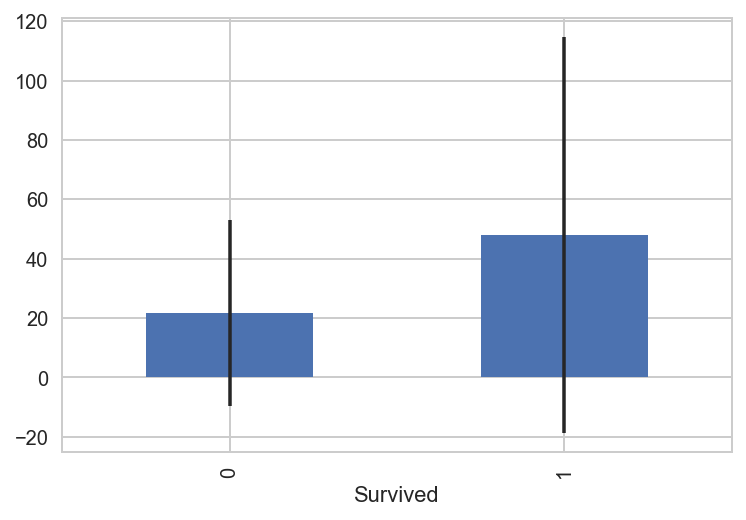

In [7]:
#补全Fare数据并画图
test.Fare = test.Fare.fillna(test.Fare.median())

data.Fare = data.Fare.astype(int)
test.Fare = test.Fare.astype(int)

fare_not_survived = data.Fare[data.Survived == 0]
fare_survived = data.Fare[data.Survived == 1]
mean_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])

data.Fare.plot(kind='hist', figsize=(15, 3), bins=100, xlim=(0, 50))

mean_fare.index.names = std_fare.index.names = ['Survived']
mean_fare.plot(yerr=std_fare, kind='bar', legend=False)

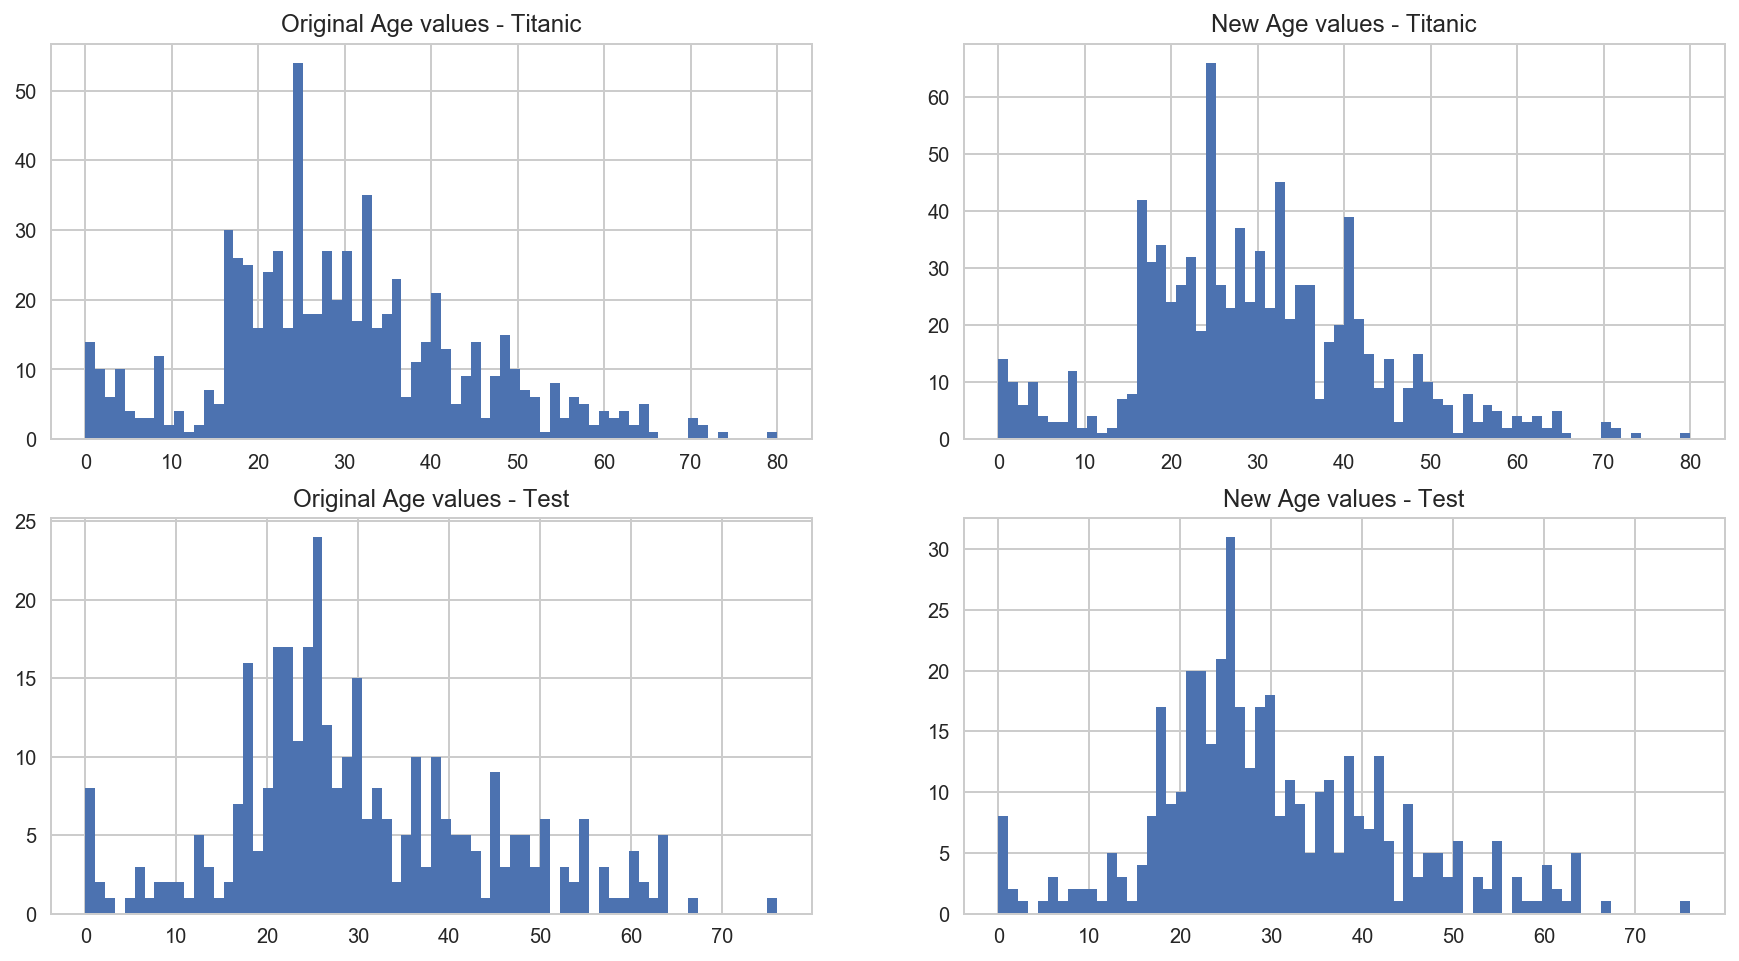

In [8]:
#Age
fig, ([axis1, axis2], [axis3, axis4]) = plt.subplots(2, 2, figsize=(15, 8))

axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')
axis3.set_title('Original Age values - Test')
axis4.set_title('New Age values - Test')

mean_age_data = data.Age.mean()
std_age_data = data.Age.std()
count_nan_age_data = data.Age.isnull().sum()

mean_age_test = test.Age.mean()
std_age_test = test.Age.std()
count_nan_age_test = test.Age.isnull().sum()

rand1 = np.random.randint(
    mean_age_data - std_age_data,
    mean_age_data + std_age_data,
    size=count_nan_age_data)
rand2 = np.random.randint(
    mean_age_test - std_age_test,
    mean_age_test + std_age_test,
    size=count_nan_age_test)

data.Age.dropna().astype(int).hist(bins=70, ax=axis1)
test.Age.dropna().astype(int).hist(bins=70, ax=axis3)

data.Age[np.isnan(data.Age)] = rand1
test.Age[np.isnan(test.Age)] = rand2

data.Age = data.Age.astype(int)
test.Age = test.Age.astype(int)
data.Age.hist(bins=70, ax=axis2)
test.Age.hist(bins=70, ax=axis4)

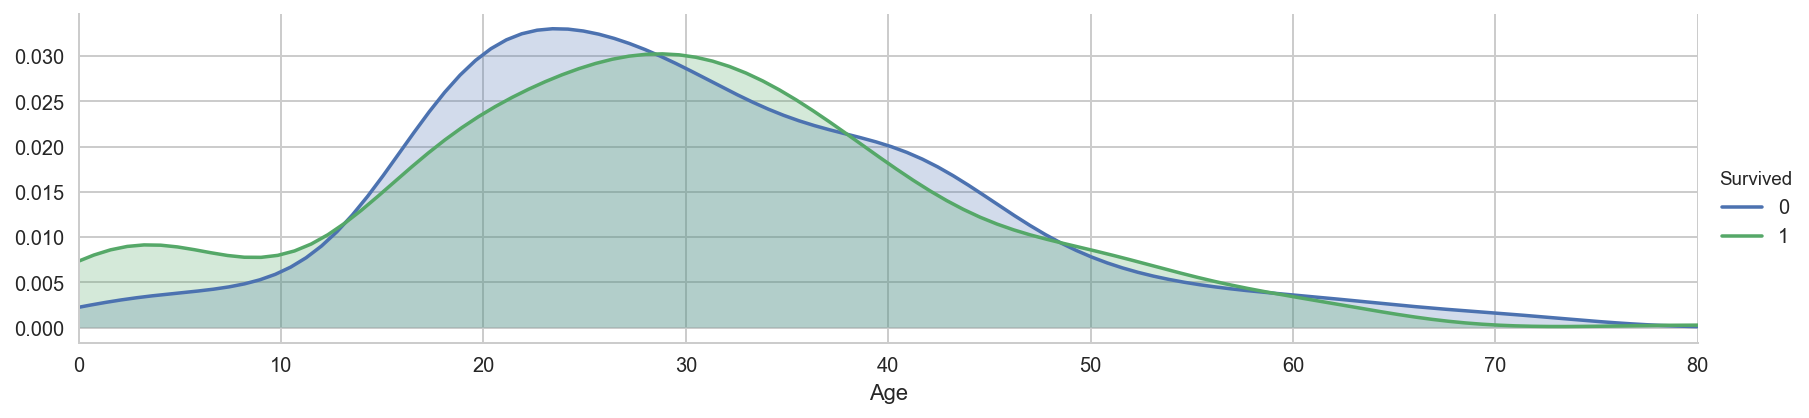

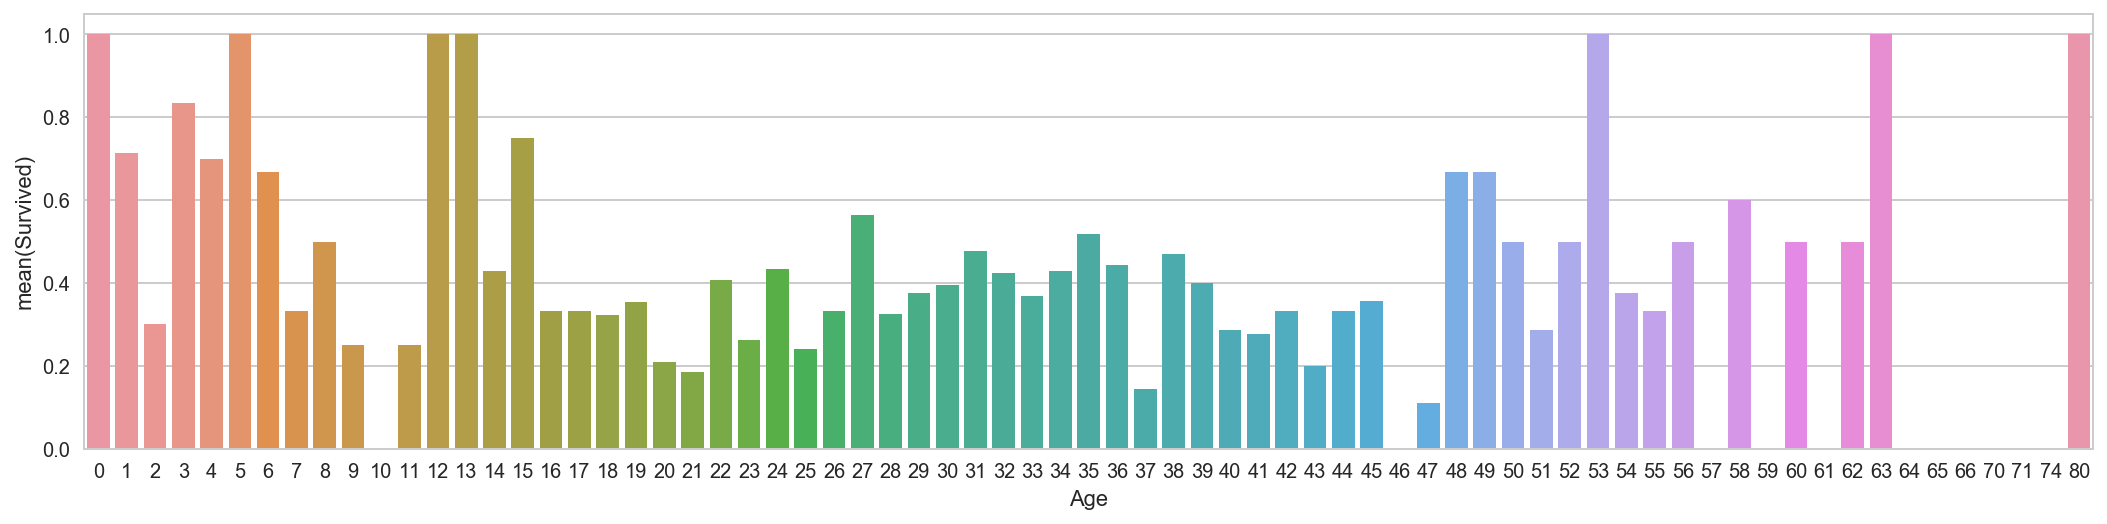

In [9]:
facet = sns.FacetGrid(data, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, data.Age.max()))
facet.add_legend()

fig, axis1 = plt.subplots(1, 1, figsize=(18, 4))
mean_age = data[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=mean_age)

In [10]:
#Cabin,空值太多直接删除
data.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

[<matplotlib.text.Text at 0x11afc3f90>, <matplotlib.text.Text at 0x11afced90>]

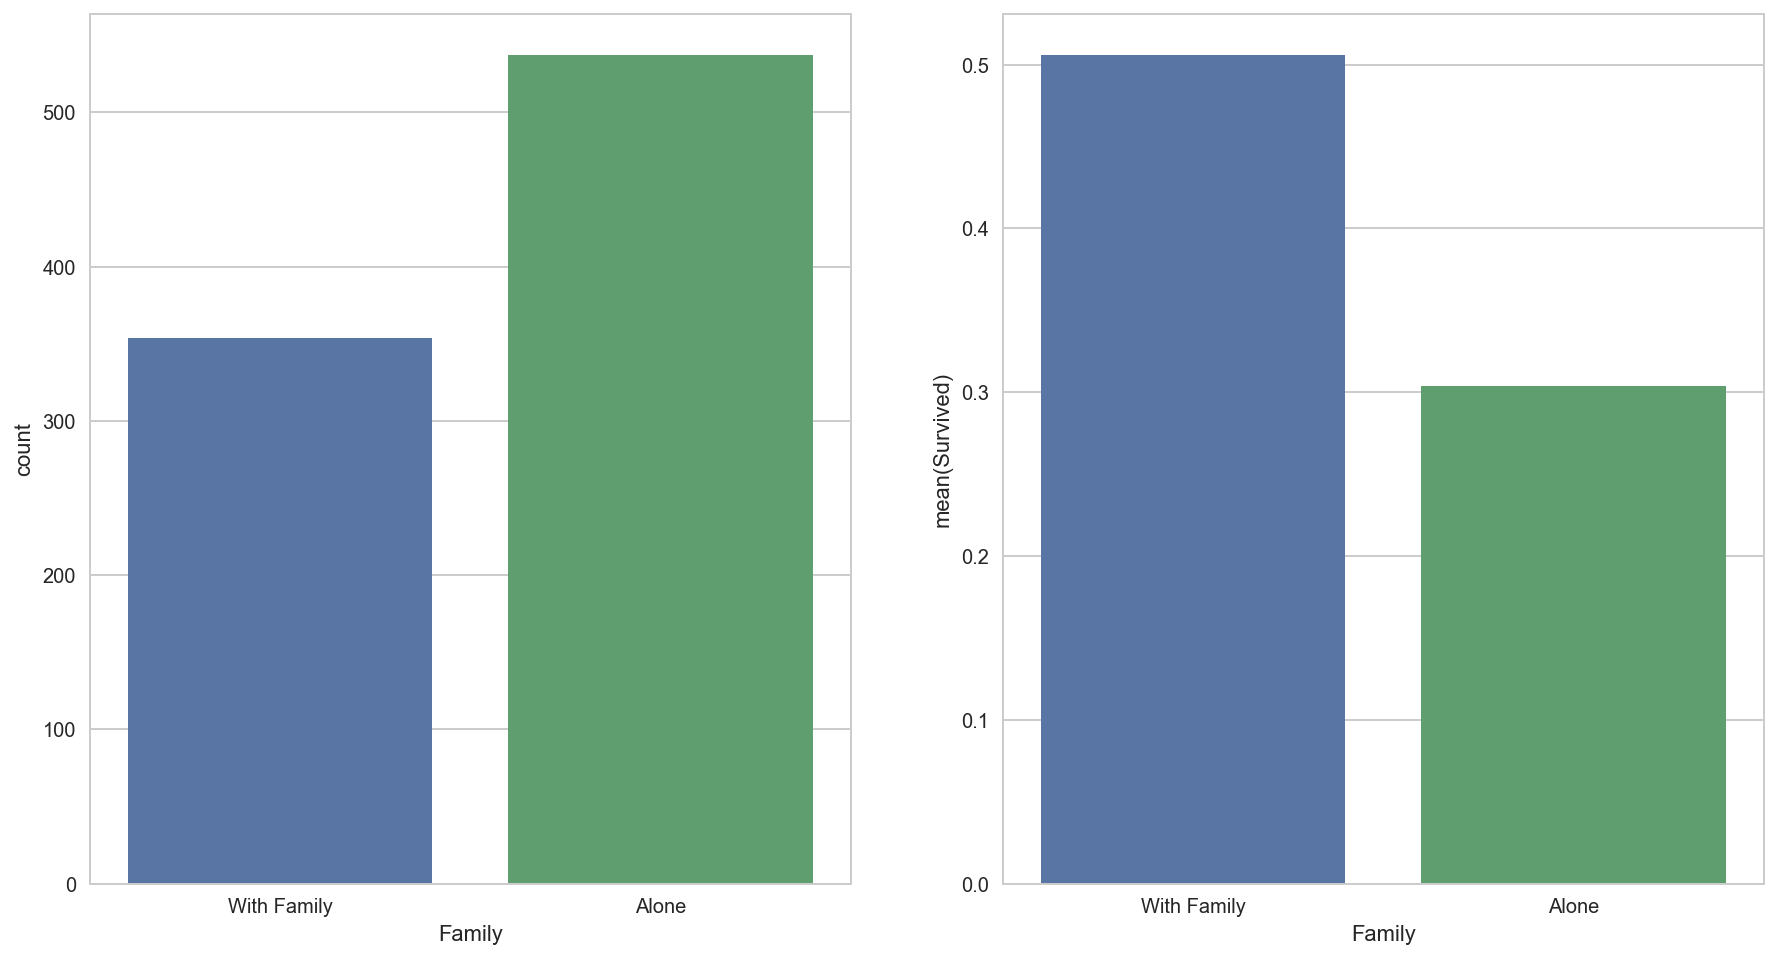

In [11]:
#Family
data['Family'] = data.SibSp + data.Parch
data.Family[data.Family > 0] = 1
data.Family[data.Family == 0] = 0
data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

test['Family'] = test.SibSp + test.Parch
test.Family[test.Family > 0] = 1
test.Family[test.Family == 0] = 0
test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot('Family', data=data, order=[1, 0], ax=axis1)
axis1.set_xticklabels(["With Family", "Alone"], rotation=0)

family_prec = data[['Family', 'Survived']].groupby(
    ['Family'], as_index=False).mean()
sns.barplot('Family', 'Survived', data=family_prec, order=[1, 0], ax=axis2)
axis2.set_xticklabels(["With Family", "Alone"], rotation=0)

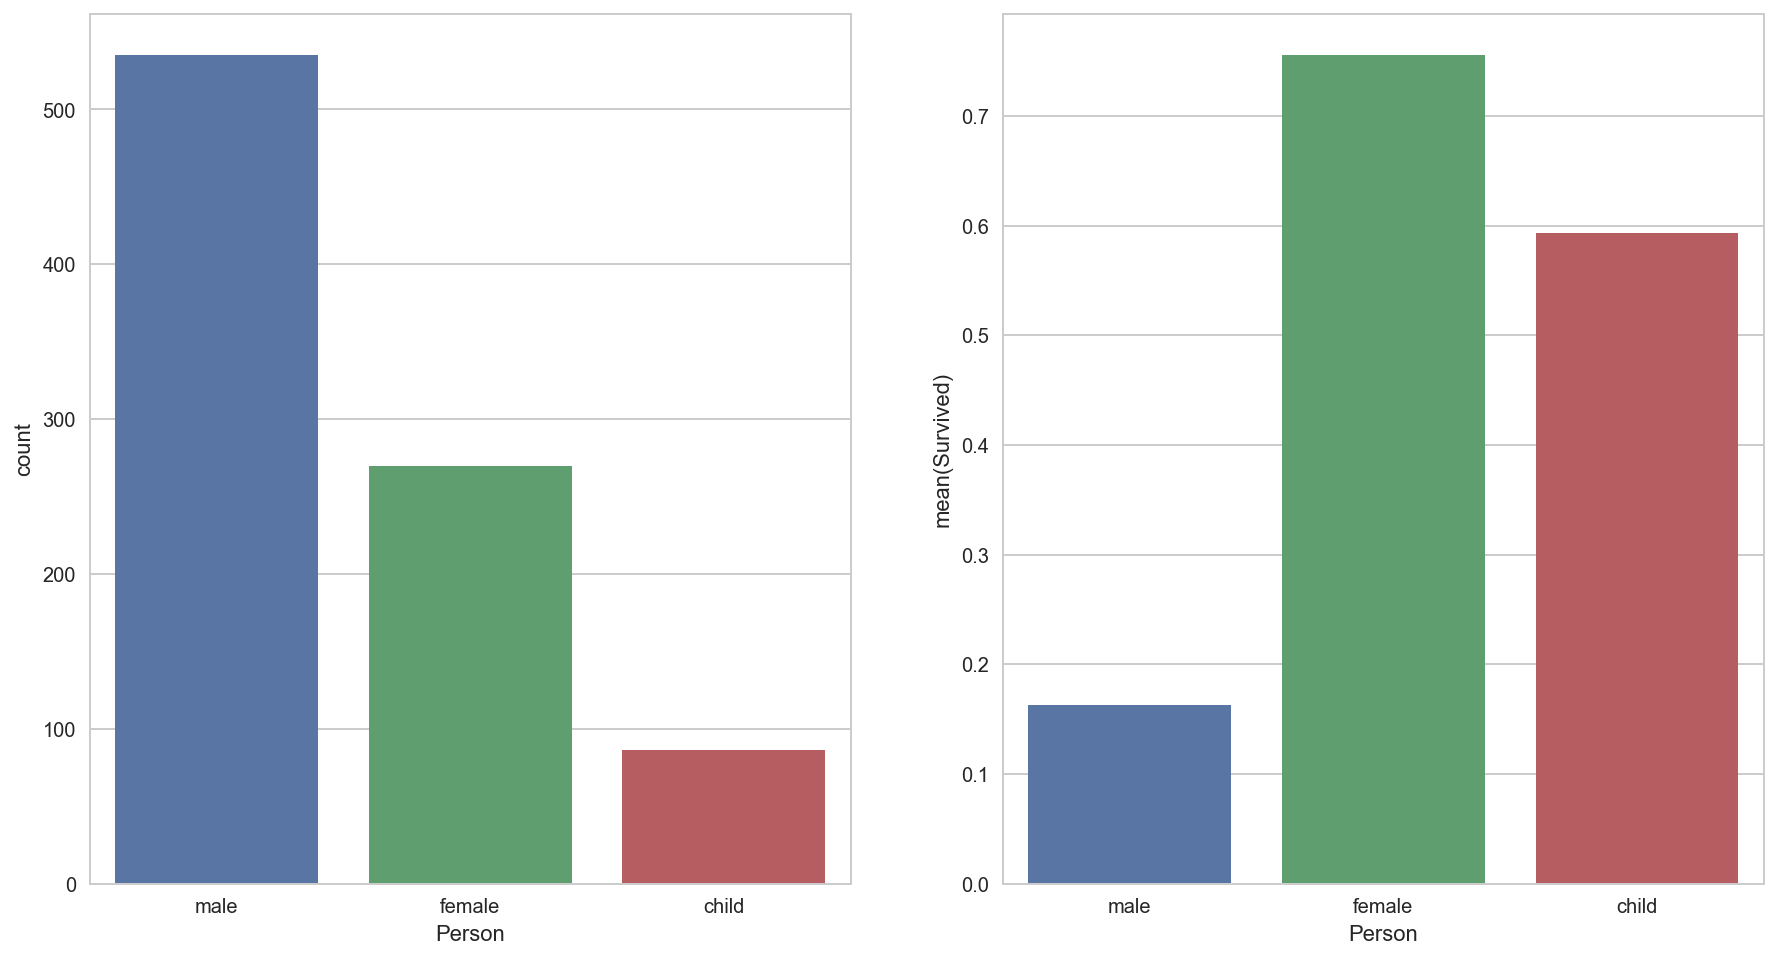

In [12]:
#Sex
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex


data['Person'] = data[['Age', 'Sex']].apply(get_person, axis=1)
data.drop(['Sex'], axis=1, inplace=True)
test['Person'] = test[['Age', 'Sex']].apply(get_person, axis=1)
test.drop(['Sex'], axis=1, inplace=True)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot('Person', data=data, ax=axis1)

person_prec = data[['Person', 'Survived']].groupby(
    ['Person'], as_index=False).mean()
sns.barplot(
    'Person',
    'Survived',
    data=person_prec,
    order=['male', 'female', 'child'],
    ax=axis2)

person_dummies_data = pd.get_dummies(data.Person)
person_dummies_data.columns = ['Child', 'Female', 'Male']
person_dummies_data.drop(['Male'], axis=1, inplace=True)
data = data.join(person_dummies_data)
data.drop(['Person'], axis=1, inplace=True)

person_dummies_test = pd.get_dummies(test.Person)
person_dummies_test.columns = ['Child', 'Female', 'Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)
test = test.join(person_dummies_test)
test.drop(['Person'], axis=1, inplace=True)

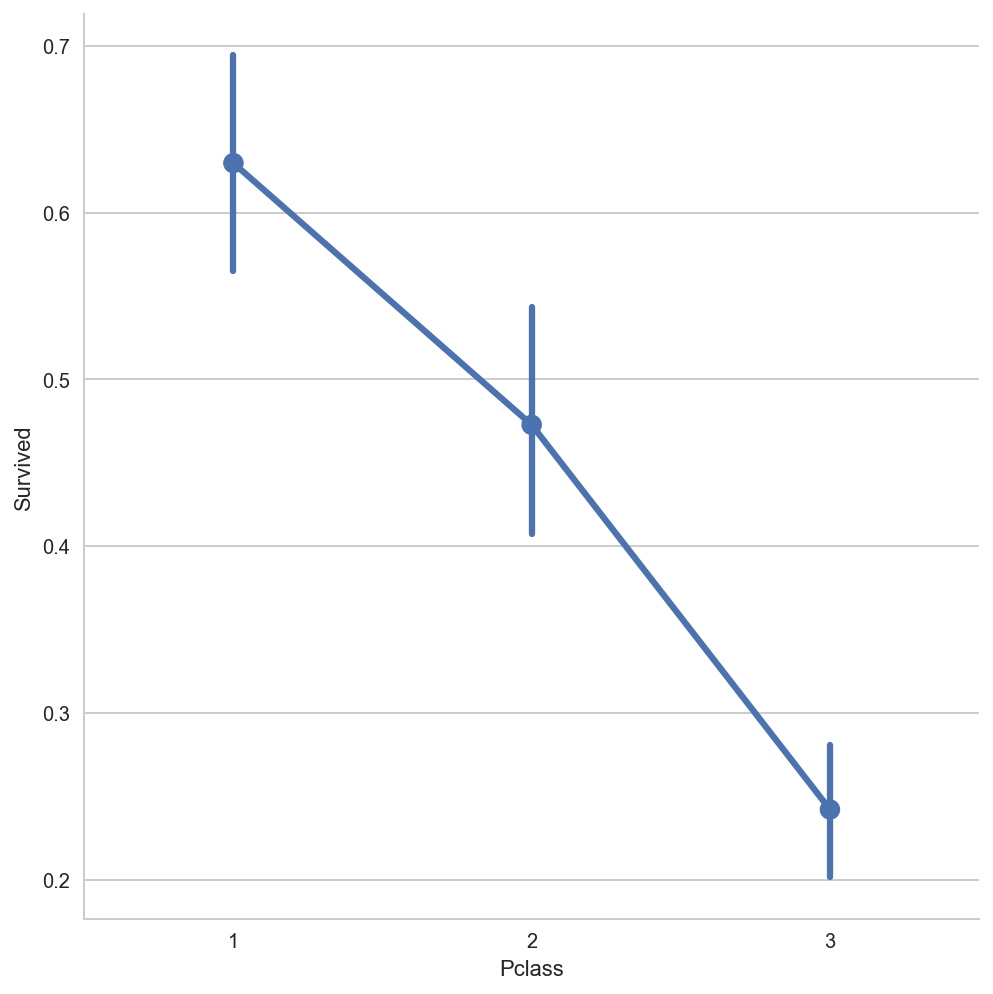

In [13]:
#Pclass
sns.factorplot('Pclass', 'Survived', data=data, size=7)

pclass_dummies_data = pd.get_dummies(data.Pclass)
pclass_dummies_data.columns = ['Class_1', 'Class_2', 'Class_3']
pclass_dummies_data.drop(['Class_1'], axis=1, inplace=True)
data = data.join(pclass_dummies_data)
data.drop(['Pclass'], axis=1, inplace=True)

pclass_dummies_test = pd.get_dummies(test.Pclass)
pclass_dummies_test.columns = ['Class_1', 'Class_2', 'Class_3']
pclass_dummies_test.drop(['Class_1'], axis=1, inplace=True)
test = test.join(pclass_dummies_test)
test.drop(['Pclass'], axis=1, inplace=True)

In [41]:
def cm_plot(y, yp):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, yp)

    import matplotlib.pyplot as plt
    plt.matshow(cm, cmap=plt.cm.Greens)
    plt.colorbar()

    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(
                cm[x, y],
                xy=(x, y),
                horizontalalignment='center',
                verticalalignment='center',
                size=15)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [15]:
#test
# embarked_dummies_data = pd.get_dummies(data.Embarked)
# embarked_dummies_data
# embarked_dummies_data.index
# mean_fare.index.name
# std_fare
# count_nan_age_data
# rand1
# data[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
data.head(10)
# test.head(10)
# family_prec
# person_dummies_data.head()
# y_test.head()

,Survived,Age,Fare,C,Q,Family,Child,Female,Class_2,Class_3
0,0,22,7,0,0,1,0,0,0,1
1,1,38,71,1,0,1,0,1,0,0
2,1,26,7,0,0,0,0,1,0,1
3,1,35,53,0,0,1,0,1,0,0
4,0,35,8,0,0,0,0,0,0,1
5,0,18,8,0,1,0,0,0,0,1
6,0,54,51,0,0,0,0,0,0,0
7,0,2,21,0,0,1,1,0,0,1
8,1,27,11,0,0,1,0,1,0,1
9,1,14,30,1,0,1,1,0,1,0


In [16]:
x_train = data.drop(['Survived'], axis=1)
y_train = data['Survived']
x_test = test.drop(['PassengerId'], axis=1).copy()
y_test = pd.read_csv('./gender_submission.csv')['Survived']

<module 'matplotlib.pyplot' from '/Users/zero/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

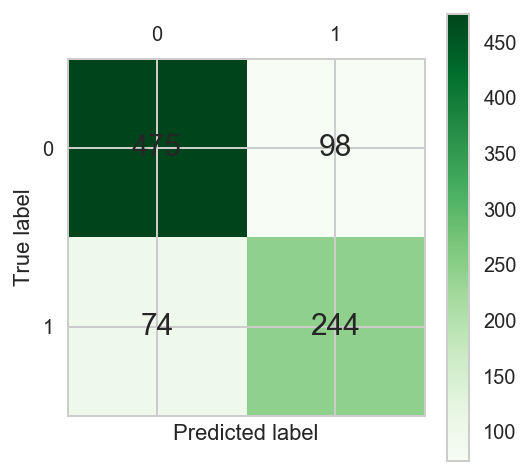

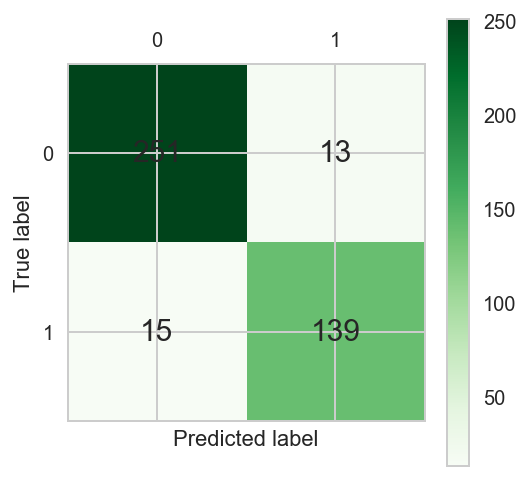

In [46]:
#Logistic Regression
model_LR = LogisticRegression()
model_LR.fit(x_train, y_train)

pred_LR = model_LR.predict(x_test)
model_LR.score(x_train, y_train)

cm_plot(y_train, model_LR.predict(x_train))
cm_plot(y_test, pred_LR)

<module 'matplotlib.pyplot' from '/Users/zero/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

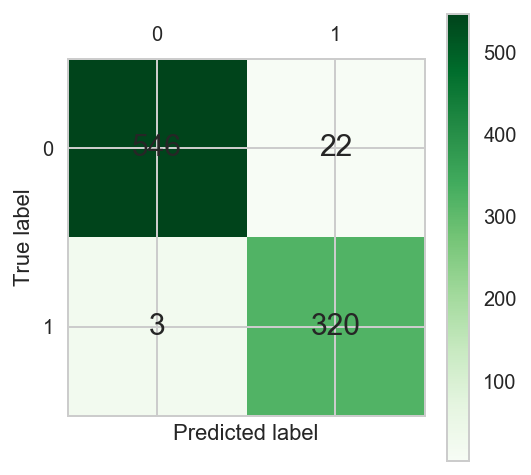

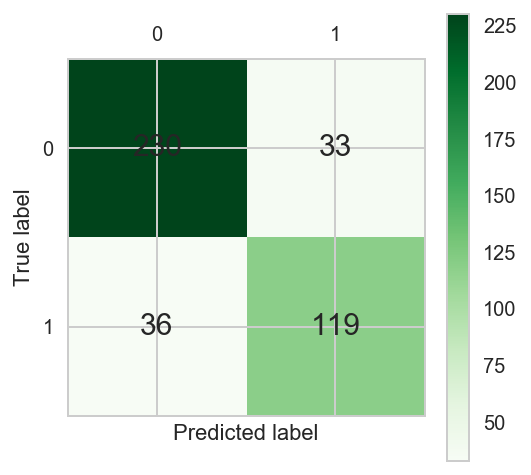

In [45]:
#Random Forests
model_RF = RandomForestClassifier(n_estimators=100)
model_RF.fit(x_train, y_train)

pred_RF = model_RF.predict(x_test)
model_RF.score(x_train, y_train)

cm_plot(y_train, model_RF.predict(x_train))
cm_plot(y_test, pred_RF)

<module 'matplotlib.pyplot' from '/Users/zero/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

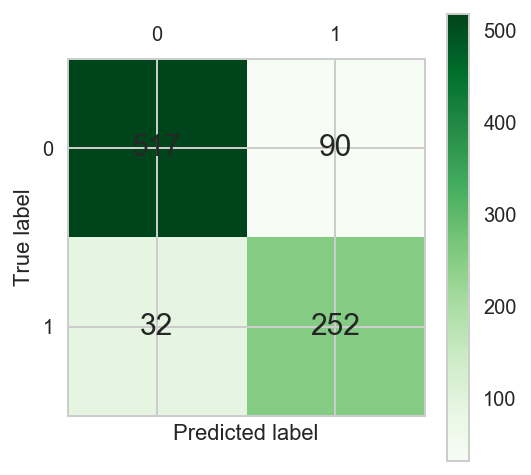

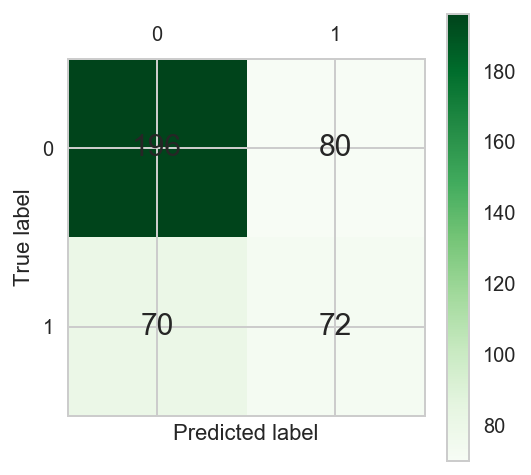

In [44]:
#Support Vector Machines
model_SVC = SVC()
model_SVC.fit(x_train, y_train)

pred_SVC = model_SVC.predict(x_test)
model_SVC.score(x_train, y_train)

cm_plot(y_train, model_SVC.predict(x_train))
cm_plot(y_test, pred_SVC)

<module 'matplotlib.pyplot' from '/Users/zero/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

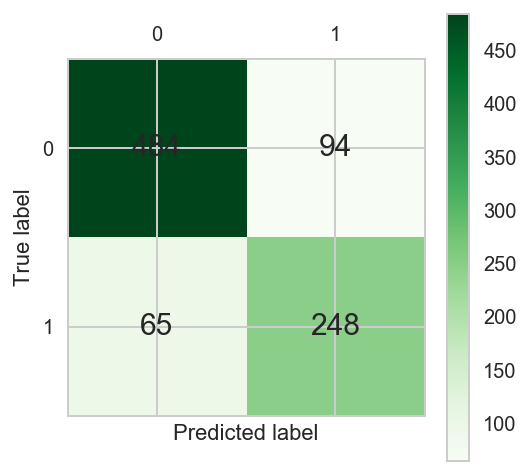

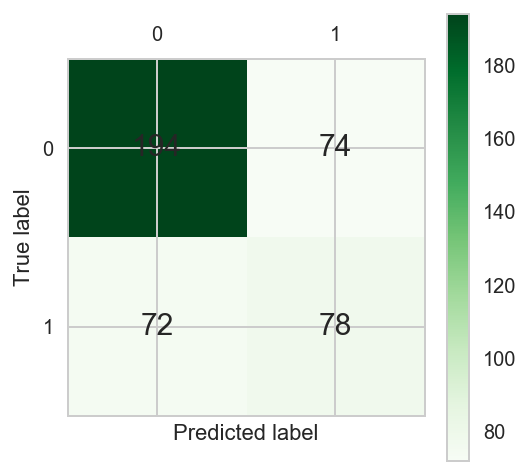

In [53]:
#KNN
model_KNN = KNeighborsClassifier(n_neighbors=3)
model_KNN.fit(x_train, y_train)

pred_KNN = model_KNN.predict(x_test)
model_KNN.score(x_train, y_train)

cm_plot(y_train, model_KNN.predict(x_train))
cm_plot(y_test, pred_KNN)

Epoch 1/100
891/891 [==============================] - 0s - loss: 1.6517     
Epoch 2/100
891/891 [==============================] - 0s - loss: 1.2043     
Epoch 3/100
891/891 [==============================] - 0s - loss: 0.9962     
Epoch 4/100
891/891 [==============================] - 0s - loss: 0.8199     
Epoch 5/100
891/891 [==============================] - 0s - loss: 0.6695     
Epoch 6/100
891/891 [==============================] - 0s - loss: 0.6085     
Epoch 7/100
891/891 [==============================] - 0s - loss: 0.5692     
Epoch 8/100
891/891 [==============================] - 0s - loss: 0.5573     
Epoch 9/100
891/891 [==============================] - 0s - loss: 0.5272     
Epoch 10/100
891/891 [==============================] - 0s - loss: 0.5248     
Epoch 11/100
891/891 [==============================] - 0s - loss: 0.5120     
Epoch 12/100
891/891 [==============================] - 0s - loss: 0.5129     
Epoch 13/100
891/891 [==============================] - 0s - 

<module 'matplotlib.pyplot' from '/Users/zero/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

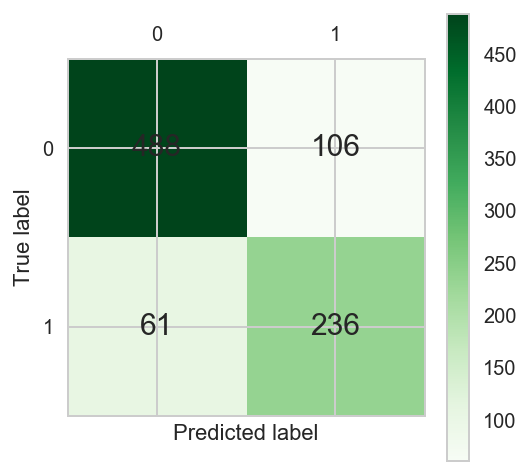

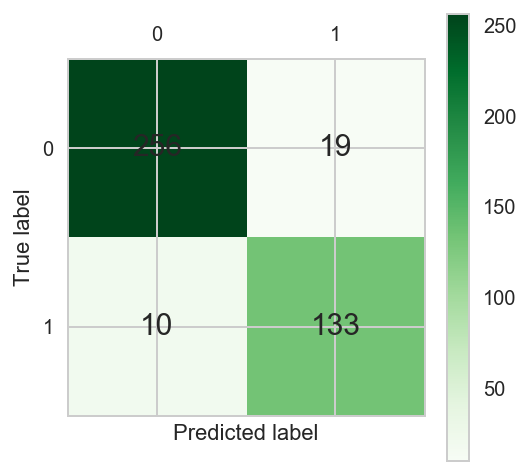

In [47]:
#CNN
model_NN = Sequential()
model_NN.add(Dense(input_dim=9, output_dim=10))
model_NN.add(Activation('relu'))
model_NN.add(Dense(input_dim=10, output_dim=1))
model_NN.add(Activation('sigmoid'))
model_NN.compile(loss='binary_crossentropy', optimizer='adam')
model_NN.fit(
    x_train.as_matrix(), y_train.as_matrix(), epochs=100, batch_size=10)

pred_NN = model_NN.predict_classes(x_test.as_matrix()).reshape(len(y_test))
model_NN.score(x_train, y_train)

cm_plot(y_train,
        model_NN.predict_classes(x_train.as_matrix()).reshape(len(y_train)))
cm_plot(y_test, pred_NN)